In [3]:
!pip install d2l==1.0.0-beta0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 28.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.3 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616823 sha256=91a703c277612ebe12b6384dc1bacab336053121c59c009472d6ef47b51d1f04
  Stored in directory: /root/.cache/pip/wheels/27/6d/b3/a3a6e10704795c9b9000f1ab2dc480dfe7bed42f5972806e73
Successfully built gym
  Attempting uninstal

Trong phần giới thiệu về hồi quy tuyến tính, chúng ta đã xem qua các thành phần khác nhau bao gồm dữ liệu, mô hình, hàm mất mát và thuật toán tối ưu hóa. Thật vậy, hồi quy tuyến tính là một trong những mô hình học máy đơn giản nhất. Tuy nhiên, việc đào tạo nó sử dụng nhiều thành phần giống như các mô hình khác trong cuốn sách này yêu cầu. Do đó, trước khi đi sâu vào chi tiết triển khai, bạn nên thiết kế một số API được sử dụng xuyên suốt cuốn sách này. Đối xử với các thành phần trong học sâu như các đối tượng, chúng ta có thể bắt đầu bằng cách xác định các lớp cho các đối tượng này và các tương tác của chúng. Thiết kế hướng đối tượng này để triển khai sẽ hợp lý hóa đáng kể bản trình bày và thậm chí bạn có thể muốn sử dụng nó trong các dự án của mình.

Chúng ta muốn có ba Class: 
  
  (i) Module chứa các mô hình, loss và phương pháp tối ưu hóa; 
  
  (ii) DataModule cung cấp trình tải dữ liệu để đào tạo và xác nhận; 
  
  (iii) Cả hai Class được kết hợp bằng cách sử dụng Class Trainer, cho phép chúng ta đào tạo các mô hình trên nhiều nền tảng phần cứng khác nhau. Hầu hết mã trong cuốn sách này điều chỉnh Module và DataModule. 
  
Chúng ta sẽ chỉ đề cập đến Trainerlớp này khi thảo luận về GPU, CPU, đào tạo song song và các thuật toán tối ưu hóa.

In [4]:
import time
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# 3.2.1. Tiện ích, tính năng

Hàm tiện ích đầu tiên cho phép chúng ta đăng ký các hàm dưới dạng các phương thức trong một lớp sau khi lớp đó đã được tạo. Trên thực tế, chúng ta có thể làm như vậy ngay cả sau khi đã tạo các thể hiện của lớp! Nó cho phép chúng ta chia nhỏ việc triển khai một lớp thành nhiều khối mã.

In [5]:
def add_to_class(Class): 
  """Đăng ký hàm như một phương thức trong Class đã tạo"""
  def wrapper(obj):
    setattr(Class, obj.__name__, obj)
  return wrapper

Chúng ta hãy xem nhanh cách sử dụng nó

In [6]:
class A:
  def __init__(self):
    self.b = 1

a = A()

Tiếp theo sẽ định nghĩa một phương thức `do` nhưng không nằm trong phạm vi của class bằng cách sử dụng `add_to_class`.

In [7]:
@add_to_class(A)
def do(self):
  print('Class attribute "b" is', self.b)
  
@add_to_class(A)
def Hello(self):
  print('Hello mày')
a.do()
a.Hello()

Class attribute "b" is 1
Hello mày


Tiện ích thứ 2 là lưu tất cả các đối số trong phương thức `__init__` của class dưới dạng thuộc tính. 

In [8]:
class HyperParameters:
  def save_hyperparameters(self, ignore = []):
    raise NotImplemented

Để sử dụng nó, ta cần kế thừa và sử dụng phương thức `save_hyperparameters` trong hàm khởi tạo `__init__`

In [9]:
class B(d2l.HyperParameters):
  def __init__(self, A, B, C):
    self.save_hyperparameters(ignore=['C'])
    print('self.A =', self.A, 'self.B =', self.B)
    print('There is no self.C =', not hasattr(self, 'C'))

b = B(A=1, B=2, C=3)

self.A = 1 self.B = 2
There is no self.C = True


Tiện ích cuối cùng cho phép chúng tôi vẽ sơ đồ tiến trình thử nghiệm một cách tương tác trong khi nó đang diễn ra.
Trong ví dụ sau, chúng ta vẽ $sin$ và $cos$ với một độ mịn khác. Nếu bạn chạy khối mã này, bạn sẽ thấy các đường trong cùng một biểu đồ.

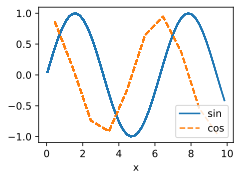

In [10]:
board = d2l.ProgressBoard('x')
for x in np.arange(0, 10 , 0.1):
  board.draw(x, np.sin(x), 'sin', every_n = 2)
  board.draw(x, np.cos(x), 'cos', every_n = 10)

# 3.2.2. Model

Class Module là Class cơ sở của tất cả các mô hình mà ta sẽ triển khai. Tối thiểu cần 3 phương thức:

*   Phương thức `__init__` lưu trữ các tham số có thể học được.
*   Phương thức `training_step` nhận vào một batch dữ liệu và trả về giá trị mất mát (loss)
*   Phương thức `configure_optimizers` trả về phương thức tối ưu hoặc 1 list của chúng, được dùng để cập nhật các tham số có thể học được. 

Ta có thể định nghĩa `validation_step` để báo cáo các biện pháp đánh giá. Đôi khi, chúng ta đặt mã để tính toán đầu ra thành một phương thức `forward` riêng để làm cho nó dễ sử dụng lại hơn. 


In [11]:
class Module (nn.Module, d2l.HyperParameters):
  """The base class of models"""
  def __init__(self, plot_train_per_epoch = 2, plot_valid_per_epoch = 1):
    super().__init__()
    self.save_hyperparameters()
    self.board = d2l.ProgressBoard()

  def loss(self, y_hat, y):
    raise NotImplementedError

  def forward(self, X):
    assert hasattr(self, 'net'), 'Neural network is defined'
    return self.net(X)

  def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches # Toán tử gì đây ?!
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))
  def training_step(self, batch):
    l = self.loss(self(*batch[:-1]), batch[-1])
    self.plot('loss', l, train = True)
    return l

  def validation_step(self, batch):
    l = self.loss(self(*batch[:-1]), batch[-1])
    self.plot('loss', l, train = False)

  def configure_optimizers(self):
    raise NotImplementedError

  

Ta có thế thấy rằng class Module là 1 class con của nn.Module, lớp cơ sở của các mạng nơ ron trong PyTorch. 

# 3.2.3. Dữ liệu

Class DataModule là lớp cơ sở cho dữ liệu. Khá thường xuyên khi phương thức `__init__` được sử dụng để chuẩn bị cho dữ liệu bao gồm tải và tiền xử lý nếu cần. `train_dataloader` trả về dữ liệu để training. Dataloader là một trình tạo ra một lô dữ liệu mỗi khi được sử dụng. Sau đó được đưa vào `training_step` để tính toán loss. Có một tùy chọn `val_dataloader` để trả về tập dữ liệu validation. Dùng để truyền vào phương thức `validation_step` trong `Module`.

In [12]:
class DataModule(d2l.HyperParameters):
  def __init__(self, root = '../data', num_workers = 4):
    self.save_hyperparameters()

  def get_dataloader(self, train):
        raise NotImplementedError

  def train_dataloader(self):
        return self.get_dataloader(train=True)

  def val_dataloader(self):
        return self.get_dataloader(train=False)
  

# 3.2.4 Training

Class Trainer huấn luyện các tham số có thể học được trong Class Module với dữ liệu được chỉ định trong class DataModule. Phương thức chính là `fit`, chấp nhận 2 đối số: model và data. Và thực hiện lặp theo với `max_epochs` lần.

In [13]:
class Trainer(d2l.HyperParameters):
  def __init__(self, max_epochsm, num_gpus= 0, gradient_clip_val = 0):
    self.save_hyperparameters()
    assert num_gpus == 0, 'No GPU support yet'
  def prepare_data(self, data):
    self.train_dataloader = data.train_dataloader()
    self.val_dataloader = data.val_dataloader()
    self.num_train_batches = len(self.train_dataloader)
    self.num_val_batches = (len(self.val_dataloader)
                              if self.val_dataloader is not None else 0)
  def prepare_model (self, model):
    model.trainer = self
    model.board.xlim = [0, self.max_epochs]
    self.model = model

  def fit(self, model, data):
    self.prepare_data(data)
    self.prepare_model(model)
    self.optim = model.configure_optimizers()
    self.epoch = 0
    self.train_batch_idx = 0
    self.val_batch_idx = 0
    for self.epoch in range(self.max_epochs):
      self.fit_epoch()
  
  def fit_epoch(self):
    raise NotImplementedError

# 3.2.5. Tổng kết

Để làm nổi bật thiết kế hướng đối tượng cho việc triển khai học sâu, các lớp trên chỉ hiển thị cách các đối tượng của chúng lưu trữ dữ liệu và tương tác với nhau. Để hiểu rõ cần đọc thêm trong sách. Ngoài ra, các lớp được triển khai đầy đủ này được lưu trong thư viện d2l , một bộ công cụ nhẹ giúp tạo mô hình có cấu trúc để học sâu dễ dàng. Đặc biệt, nó tạo điều kiện tái sử dụng nhiều thành phần giữa các dự án mà không thay đổi nhiều. Chẳng hạn, chúng ta có thể chỉ thay thế bộ tối ưu hóa, chỉ mô hình, chỉ bộ dữ liệu, v.v.; mức độ mô đun hóa này mang lại hiệu quả xuyên suốt cuốn sách về tính ngắn gọn và đơn giản (đây là lý do tại sao chúng tôi thêm nó vào) và nó có thể làm điều tương tự cho các dự án của riêng bạn.